# Triangular Lagrangian Second Order Elements 
The <b>goal</b> of this notebook is to implement second order Lagrange shape functions on triangular elements.

Remark
- the reference element for quadrature has vertices $(\xi_1,\eta_1) = (0,0)$, $(\xi_2,\eta_2) =(1,0)$ and $(\xi_3,\eta_3) = (0,1)$; 

This notebook is structured as follows: 

## Import Packages

In [13]:
using LinearAlgebra
using FastGaussQuadrature
using Plots
using SparseArrays
using BenchmarkTools 
using Test

In [14]:
include("quadrature.jl")

compute_weights_triangle

## Section 1:/ Introduction 

In [67]:
function area_triangle(x1,x2,x3)
    l3 = norm(x[1]-x[2])
    l2 = norm(x[1]-x[3])
    l1 = norm(x[2]-x[3])

    lc = 0.5 * (l1+l2+l3)
    area = sqrt(lc*(lc-l1)*(lc-l2)*(lc-l3))
    
    return area
end 

area_triangle (generic function with 1 method)

In [69]:
x1 = [0,0]; x2 = [2,0]; x3 = [0,-2];
area = area_triangle(x1,x2,x3) 

0.4999999999999998

## Section 2:/ Verification using Linear Shape Functions 

In [40]:
# polynomial degree to FE approximation  
pdegree = 1;
# degree of numerical quadrature 
qorder = 4; 
xi = compute_coordinates_triangle(qorder)
w  = compute_weights_triangle(qorder)
display(xi)
display(w)

9-element Vector{Vector{Float64}}:
 [0.1127016653792583, 0.09999999999999999]
 [0.1127016653792583, 0.44364916731037085]
 [0.1127016653792583, 0.7872983346207417]
 [0.5, 0.05635083268962915]
 [0.5, 0.25]
 [0.5, 0.44364916731037085]
 [0.8872983346207417, 0.012701665379258308]
 [0.8872983346207417, 0.05635083268962915]
 [0.8872983346207417, 0.09999999999999999]

9-element Vector{Float64}:
 0.06846437767135354
 0.10954300427416563
 0.06846437767135354
 0.06172839506172839
 0.09876543209876543
 0.06172839506172839
 0.008696116155806968
 0.01391378584929115
 0.008696116155806968

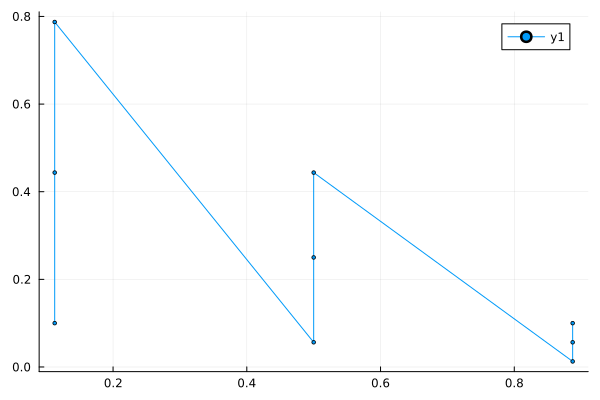

In [41]:
xxi = [xi1[1] for xi1 in xi]
yxi = [xi1[2] for xi1 in xi]
plot(xxi, yxi,marker=2)
# display(xxi)
# display(yxi)

In [18]:
# computation of the coefficients of the basis functions 
x = [[0.,0.], [1.,0], [0.,1.]]
X = [[x1[1], x1[2], 1] for x1 in x]
X = reduce(vcat,transpose(X))
I = [1. 0 0; 0 1. 0; 0 0 1.]; 
Emat = X\I

3×3 Matrix{Float64}:
 -1.0  1.0  0.0
 -1.0  0.0  1.0
  1.0  0.0  0.0

In [55]:
# set coordinates of physical point 
x1 = [0.,0.]; x2 = [2.,0.]; x3 = [0.,2.];  
T = zeros(2,2); T[:,1] = x2 - x1; T[:,2] = x3 - x1; 
# vector of quadrature points on the physical finite element 
xs = [T*xi1+x1 for xi1 in xi];
# Vandermonde Matrix for evaluation of the basis functions
Xs = zeros(length(w),3);   
Xs = [[xs1[1], xs1[2], 1] for xs1 in xs];
Xs = reduce(vcat,transpose(Xs))
# Vandermonde Matrix for evaluation of the x/y derivatives of basis functions
dxXs = zeros(length(w),3);
dxXs = [[1, 0, 0] for xs1 in xs];
dxXs = reduce(vcat,transpose(dxXs))
dyXs = zeros(length(w),3);
dyXs = [[0, 1, 0] for xs1 in xs];
dyXs = reduce(vcat,transpose(dyXs))
display(dxXs)

9×3 Matrix{Int64}:
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0
 1  0  0

In [58]:
# column basis and derivative of the basis vectors  
Phi   = Xs*Emat; 
dxPhi = dxXs*Emat; 
dyPhi = dyXs*Emat; 
display(dyPhi)

9×3 Matrix{Float64}:
 -1.0  0.0  1.0
 -1.0  0.0  1.0
 -1.0  0.0  1.0
 -1.0  0.0  1.0
 -1.0  0.0  1.0
 -1.0  0.0  1.0
 -1.0  0.0  1.0
 -1.0  0.0  1.0
 -1.0  0.0  1.0

In [70]:
dxPhidxPhi = zeros(length(w),9);
[dxPhidxPhi[:,(j-1)*3+i] = dxPhi[:,i].*dxPhi[:,j] for i=1:3,j=1:3];
dyPhidyPhi = zeros(length(w),9);
[dyPhidyPhi[:,(j-1)*3+i] = dyPhi[:,i].*dyPhi[:,j] for i=1:3,j=1:3];
dPhidPhi = dxPhidxPhi + dyPhidyPhi; 
area = area_triangle(x1,x2,x3)
Aloc = 2*area*Transpose(w)*dPhidPhi
display(reshape(Aloc,3,3))

3×3 reshape(transpose(::Vector{Float64}), 3, 3) with eltype Float64:
  1.0  -0.5  -0.5
 -0.5   0.5   0.0
 -0.5   0.0   0.5